<a href="https://colab.research.google.com/github/vasanthbijibilla/vasanthbijibilla/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [108]:
import numpy as np
from os import listdir, mkdir
from os.path import isfile, join
import h5py as h5
import matplotlib.pyplot as plt

In [109]:
export_to = 'random-iter-1/'

In [110]:
mkdir(export_to)
print("Directory created")

FileExistsError: ignored

In [112]:
# Mapping from folder names (ZONFS) to set names (ABCDE)

mapping_set_to_dir = {
    'A': (0,'Z'),
    'B': (1,'O'),
    'C': (2,'N'),
    'D': (3,'F'),
    'E': (4,'S')
}

file_lists = []
for s,d in mapping_set_to_dir.items():
    file_lists.insert(d[0], [f for f in listdir(d[1]) if isfile(join(d[1], f))])

In [113]:
file_lists[4]

['S070.txt',
 'S033.txt',
 'S035.txt',
 'S014.txt',
 'S027.txt',
 'S030.txt',
 'S041.txt',
 'S049.txt',
 'S044.txt',
 'S087.txt',
 'S015.txt',
 'S021.txt',
 'S098.txt',
 'S053.txt',
 'S022.txt',
 'S094.txt',
 'S060.txt',
 'S007.txt',
 'S050.txt',
 'S100.txt',
 'S081.txt',
 'S091.txt',
 'S043.txt',
 'S084.txt',
 'S099.txt',
 'S057.txt',
 'S051.txt',
 'S065.txt',
 'S073.txt',
 'S071.txt',
 'S039.txt',
 'S056.txt',
 'S023.txt',
 'S052.txt',
 'S025.txt',
 'S074.txt',
 'S002.txt',
 'S072.txt',
 'S004.txt',
 'S064.txt',
 'S068.txt',
 'S097.txt',
 'S019.txt',
 'S069.txt',
 'S012.txt',
 'S031.txt',
 'S038.txt',
 'S085.txt',
 'S020.txt',
 'S058.txt',
 'S088.txt',
 'S077.txt',
 'S009.txt',
 'S062.txt',
 'S047.txt',
 'S010.txt',
 'S013.txt',
 'S095.txt',
 'S092.txt',
 'S040.txt',
 'S001.txt',
 'S024.txt',
 'S026.txt',
 'S034.txt',
 'S083.txt',
 'S037.txt',
 'S054.txt',
 'S046.txt',
 'S086.txt',
 'S006.txt',
 'S066.txt',
 'S055.txt',
 'S042.txt',
 'S016.txt',
 'S017.txt',
 'S032.txt',
 'S079.txt',

In [114]:
raw_dataset = { }

for s,d in mapping_set_to_dir.items():
    
    for f in file_lists[d[0]]:
        curr_example = np.loadtxt(join(d[1], f))
        

        if (s in raw_dataset):
            raw_dataset[s] = np.append(raw_dataset[s], [curr_example], axis=0)
        else:
            raw_dataset[s] = np.array([curr_example])

In [115]:
raw_dataset['E'].shape

(100, 4097)

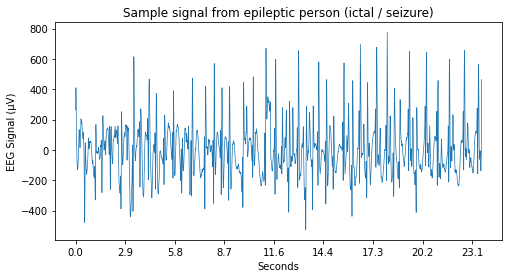

In [116]:
s = 'E'
index = 46

plot_title = ''
if (s in ['A', 'B']):
    plot_title = 'Sample signal from non-epileptic person'
elif (s in ['C', 'D']):
    plot_title = 'Sample signal from epileptic person (non-ictal / non-seizure)'
elif (s == 'E'):
    plot_title = 'Sample signal from epileptic person (ictal / seizure)'
else:
    print('s can be one of A,B,C,D,E')

plt.figure(figsize=(8,4))
plt.plot(raw_dataset[s][index], linewidth=0.7)
plt.title(plot_title)
plt.xlabel('Seconds')
plt.ylabel('EEG Signal (\u00B5V)')
tick_points = np.arange(0,9)*500 # each signal contains 4097 data points
plt.xticks(tick_points, np.round((tick_points/173.16)*10)/10) # mapping n-th data point to the time in seconds from the start of signal (173.16 Hz)
plt.show()

In [117]:
def create_augmented_dataset(raw_dataset, window_size = 512, stride = 64, verbose=False):
    """
    This function augments the dataset using sliding windows
    
    Parameters:
    raw_dataset: Dictionary containing a batch of examples for one set in each key
    window_size: Sliding window size
    stride: Steps by which sliding window moves and samples
    verbose: Display progress
    
    Returns:
    augmented_dataset: Dictionary containing a batch of smaller augmented examples than raw_dataset
    
    
    """
    
    augmented_dataset = { }

    for s,Xset_raw in raw_dataset.items():
        
        if (verbose):
            print('Processing set ' + s)

        total_points = Xset_raw.shape[1]

        # no. of examples generated from single training example using sliding window
        # = floor((total_points - window_size) / stride) + 1
        iterations = ((total_points - window_size) // stride) + 1

        for x_raw in Xset_raw:

            for i in range(iterations):
                window_slice_from = i*stride
                window_slice_to = i*stride + window_size

                if (s in augmented_dataset):
                    augmented_dataset[s] = np.append(augmented_dataset[s], [x_raw[window_slice_from:window_slice_to]], axis=0)
                else:
                    augmented_dataset[s] = np.array([x_raw[window_slice_from:window_slice_to]])

    
    if (verbose):
        print('Done.')
    return augmented_dataset

In [118]:
raw_dataset_train = { }
raw_dataset_dev = { }
raw_dataset_test = { }

for s,Xset_raw in raw_dataset.items():
    
    # randomly shuffle the data, just to make sure
    # that all train/dev/test sets come from same
    # distribution, (possibly not from a same person)
    np.random.shuffle(raw_dataset[s])
    
    ninety_percent = np.floor(0.9 * raw_dataset[s].shape[0]).astype(int)
    five_percent = np.floor(0.05 * raw_dataset[s].shape[0]).astype(int)
    
    # train set 0 - 89 (90%)
    raw_dataset_train[s] = raw_dataset[s][0:ninety_percent,:]
    
    # dev set 90 - 94 (5%)
    raw_dataset_dev[s] = raw_dataset[s][ninety_percent:ninety_percent+five_percent,:]
    
    # test set 95 - 99 (5%)
    raw_dataset_test[s] = raw_dataset[s][ninety_percent+five_percent:,:]

In [119]:
print(raw_dataset_train['D'].shape)
print(raw_dataset_dev['A'].shape)
print(raw_dataset_test['C'].shape)

(90, 4097)
(5, 4097)
(5, 4097)


In [120]:
print("Augmenting training data")
aug_dataset512_train = create_augmented_dataset(raw_dataset_train, window_size=512, stride=64, verbose=True)

print("Augmenting dev data")
aug_dataset512_dev = create_augmented_dataset(raw_dataset_dev, window_size=512, stride=256, verbose=True)

print("Augmenting test data")
aug_dataset512_test = create_augmented_dataset(raw_dataset_test, window_size=512, stride=256, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [121]:
print('Augmenting training data')
aug_dataset1024_train = create_augmented_dataset(raw_dataset_train, window_size=1024, stride=128, verbose=True)

print ('Augmenting dev data')
aug_dataset1024_dev = create_augmented_dataset(raw_dataset_dev, window_size=1024, stride=512, verbose=True)

print('Augmenting test data')
aug_dataset1024_test = create_augmented_dataset(raw_dataset_test, window_size=1024, stride=512, verbose=True)

Augmenting training data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting dev data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.
Augmenting test data
Processing set A
Processing set B
Processing set C
Processing set D
Processing set E
Done.


In [122]:
print(aug_dataset512_train['E'].shape)
print(aug_dataset512_dev['C'].shape)
print(aug_dataset512_test['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [123]:
print(aug_dataset1024_train['E'].shape)
print(aug_dataset1024_dev['C'].shape)
print(aug_dataset1024_test['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


In [124]:
with h5.File(export_to + 'aug_dataset512.h5', 'w') as aug_file512:
    
    train512 = aug_file512.create_group('train')
    dev512 = aug_file512.create_group('dev')
    test512 = aug_file512.create_group('test')

    for s in aug_dataset512_train.keys():
        
        train512.create_dataset(s, data=aug_dataset512_train[s])
        dev512.create_dataset(s, data=aug_dataset512_dev[s])
        test512.create_dataset(s, data=aug_dataset512_test[s])
        

In [125]:
with h5.File(export_to + 'aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])

In [126]:

with h5.File(export_to + 'aug_dataset1024.h5', 'w') as aug_file1024:
    
    train1024 = aug_file1024.create_group('train')
    dev1024 = aug_file1024.create_group('dev')
    test1024 = aug_file1024.create_group('test')

    for s in aug_dataset1024_train.keys():
        
        train1024.create_dataset(s, data=aug_dataset1024_train[s])
        dev1024.create_dataset(s, data=aug_dataset1024_dev[s])
        test1024.create_dataset(s, data=aug_dataset1024_test[s])
aug_file512 = h5.File(export_to + 'aug_dataset512.h5', 'r')
print(aug_file512['train']['A'].shape)
print(aug_file512['dev']['C'].shape)
print(aug_file512['test']['D'].shape)

(5130, 512)
(75, 512)
(75, 512)


In [127]:
aug_file1024 = h5.File(export_to + 'aug_dataset1024.h5', 'r')
print(aug_file1024['train']['A'].shape)
print(aug_file1024['dev']['C'].shape)
print(aug_file1024['test']['D'].shape)

(2250, 1024)
(35, 1024)
(35, 1024)


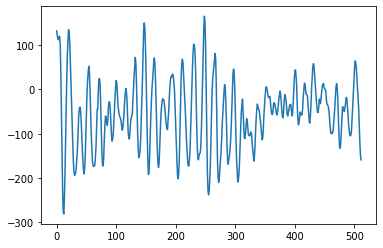

In [128]:
s = 'B'
index = 400
plt.plot(aug_file512['train'][s][index])

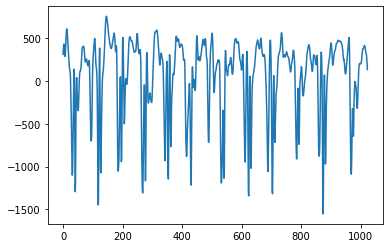

In [129]:
s = 'E'
index = 175
plt.plot(aug_file1024['train'][s][index])

In [130]:
aug_file512.close()

In [131]:
aug_file512.close()
aug_file1024.close()

In [132]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


In [133]:

# For 3 class classification
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def read_dataset_and_one_hot_labels(filepath, setname, verbose=False):
    """
    Converts the dataset's labels into one-hot encoding
    
    Parameters:
    filepath: augmented dataset without one-hot encoding
    setname: either 'train', 'dev', or 'test'
    verbose: Display progress
    
    Returns:
    data: dataset with keys X_<setname>, Y_<setname>_classname, and Y_<setname> (one-hot labels). 
    """
    
    data = { }

    # Read dataset that is already stored in the file
    with h5.File(filepath, 'r') as aug_file:

        # classes are AB, CD, and E
        no_of_classes = 3

        for s in aug_file[setname].keys():
            
            if (verbose):
                print("Processing class: " + s)
            
            class_length = len(aug_file[setname][s])
            
            # go through each example in the class
            for i in range(class_length):
                
                if (verbose and i % (class_length / 5) == 0):
                    print((str)((int)(i / class_length * 100)) + '%')
                
                # create a big (combination of all classes) dataset
                # and also set their labels in a separate array
                if (('X_' + setname) in data):
                    data['X_' + setname] = np.append(data['X_' + setname], [aug_file[setname][s][i]], axis=0)
                    data['Y_' + setname + '_classname'] = np.append(data['Y_' + setname + '_classname'], [class_map[s]], axis=0)
                else:
                    data['X_' + setname] = np.array([aug_file[setname][s][i]])
                    data['Y_' + setname + '_classname'] = np.array([class_map[s]])


        
        if (verbose):
            print("Converting to one_hot")
            
        # use tensorflow one_hot function to convert labels into one_hot values
        tf.reset_default_graph()
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            data['Y_' + setname] = sess.run(tf.one_hot(data['Y_' + setname + '_classname'], depth=no_of_classes, axis=-1))
        
        if (verbose):
            print("Done.")

    return data

In [134]:
print("Converting training set to one hot")
data512_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data512_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data512_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset512.h5', 'test', verbose=True)


Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [135]:
with h5.File(export_to + 'datafile512.h5', 'w') as datafile512:

    datafile512.create_dataset('X_train', data=data512_train['X_train'])
    datafile512.create_dataset('Y_train_classname', data=data512_train['Y_train_classname'])
    datafile512.create_dataset('Y_train', data=data512_train['Y_train'])
    
    datafile512.create_dataset('X_dev', data=data512_dev['X_dev'])
    datafile512.create_dataset('Y_dev_classname', data=data512_dev['Y_dev_classname'])
    datafile512.create_dataset('Y_dev', data=data512_dev['Y_dev'])
    
    datafile512.create_dataset('X_test', data=data512_test['X_test'])
    datafile512.create_dataset('Y_test_classname', data=data512_test['Y_test_classname'])
    datafile512.create_dataset('Y_test', data=data512_test['Y_test'])

In [136]:
print("Converting training set to one hot")
data1024_train = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'train', verbose=True)
print("Converting dev set to one hot")
data1024_dev = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'dev', verbose=True)
print("Converting test set to one hot")
data1024_test = read_dataset_and_one_hot_labels(export_to + 'aug_dataset1024.h5', 'test', verbose=True)

Converting training set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting dev set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.
Converting test set to one hot
Processing class: A
0%
20%
40%
60%
80%
Processing class: B
0%
20%
40%
60%
80%
Processing class: C
0%
20%
40%
60%
80%
Processing class: D
0%
20%
40%
60%
80%
Processing class: E
0%
20%
40%
60%
80%
Converting to one_hot
Done.


In [137]:
with h5.File(export_to + 'datafile1024.h5', 'w') as datafile1024:

    datafile1024.create_dataset('X_train', data=data1024_train['X_train'])
    datafile1024.create_dataset('Y_train_classname', data=data1024_train['Y_train_classname'])
    datafile1024.create_dataset('Y_train', data=data1024_train['Y_train'])
    
    datafile1024.create_dataset('X_dev', data=data1024_dev['X_dev'])
    datafile1024.create_dataset('Y_dev_classname', data=data1024_dev['Y_dev_classname'])
    datafile1024.create_dataset('Y_dev', data=data1024_dev['Y_dev'])
    
    datafile1024.create_dataset('X_test', data=data1024_test['X_test'])
    datafile1024.create_dataset('Y_test_classname', data=data1024_test['Y_test_classname'])
    datafile1024.create_dataset('Y_test', data=data1024_test['Y_test'])

In [138]:
def augment_test_example(ex, window_size=512, stride=64):
    """
    Augments one dataset example with sliding window approach
    
    Used with test dataset to create multiple (typically 3) slices from one example
    The majority of the predictions on those 3 slices will be considered
    
    Parameters:
    ex: one example from dataset
    window_size: sliding window size
    stride: sliding window stride
    
    Returns:
    aug_ex: numpy array containing multiple smaller (augmented) examples
    """
    
    total_points = ex.shape[0]
    aug_ex = None
    
    # no. of examples generated from single training example using sliding window
    # = floor((total_points - window_size) / stride) + 1
    iterations = ((total_points - window_size) // stride) + 1

    for i in range(iterations):
        
        # window slice
        window_slice_from = i*stride
        window_slice_to = i*stride + window_size

        try:
            aug_ex = np.append(aug_ex, [ex[window_slice_from:window_slice_to]], axis=0)
        except:
            aug_ex = np.array([ex[window_slice_from:window_slice_to]])
    
    return aug_ex

In [139]:
class_map = { 'A': 0, 'B': 0, 'C': 1, 'D': 1, 'E': 2 }

def create_test_set_for_voting(testset, window_size=512, stride=64, divisions=2):
    """
    Augments whole test set in a way where each example contains multiple smaller slices
    
    The augmented dataset created by this function will be used by accuracy for voting measure
    Each example is divided into several divisions
    Each division consists of multiple slices (smaller examples)
    
    Parameters:
    testset: dictionary containing test examples for each class
    window_size: sliding window size
    stride: sliding window stride
    divisions: number of different examples to create from one example
    
    Returns:
    (new_test_set_X, new_test_set_Y, new_test_set_Y_onehot): numpy array of slices, labels, one-hot labels
    """
    
    new_test_set_X = None
    new_test_set_Y = []
    new_test_set_Y_onehot = None
    
    no_of_classes = 3
    identity = np.eye(no_of_classes)
    
    # loop over classes
    for c,class_data in testset.items():
        
        # loop over training examples
        for ex in class_data:
            
            for d in range(divisions):
                
                division_size = ex.shape[0] // divisions
            
                aug_ex = augment_test_example(ex[d*division_size:(d+1)*division_size], window_size=window_size, stride=stride)
                one_hot = identity[class_map[c]]

                try:
                    new_test_set_X = np.append(new_test_set_X, [aug_ex], axis=0)
                    new_test_set_Y_onehot = np.append(new_test_set_Y_onehot, [one_hot], axis=0)
                except:
                    new_test_set_X = np.array([aug_ex])
                    new_test_set_Y_onehot = np.array([one_hot])
                new_test_set_Y = np.append(new_test_set_Y, class_map[c])
        
    return new_test_set_X, new_test_set_Y, new_test_set_Y_onehot

In [140]:
test_X_v_512, test_Y_v_512, test_Y_oh_v_512 = create_test_set_for_voting(raw_dataset_test, window_size=512, stride=256, divisions=4)

In [141]:
test_X_v_1024, test_Y_v_1024, test_Y_oh_v_1024 = create_test_set_for_voting(raw_dataset_test, window_size=1024, stride=512, divisions=2)

In [142]:
print(test_X_v_512.shape)
print(test_X_v_1024.shape)

(100, 3, 512)
(50, 3, 1024)


In [143]:
with h5.File(export_to + 'testset_voting_512.h5', 'w') as testset_voting_512:
    
    testset_voting_512.create_dataset('X', data=test_X_v_512)
    testset_voting_512.create_dataset('Y', data=test_Y_v_512)
    testset_voting_512.create_dataset('Y_onehot', data=test_Y_oh_v_512)

In [144]:
with h5.File(export_to + 'testset_voting_1024.h5', 'w') as testset_voting_1024:
    
    testset_voting_1024.create_dataset('X', data=test_X_v_1024)
    testset_voting_1024.create_dataset('Y', data=test_Y_v_1024)
    testset_voting_1024.create_dataset('Y_onehot', data=test_Y_oh_v_1024)

In [145]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py as h5
from tensorflow.python.framework import ops
from os import path
import os

In [146]:
dataset_relative_path = '/content/random-iter-1'

In [147]:

datafile ='/content/random-iter-1/datafile1024.h5'

In [148]:
with h5.File(datafile, 'r') as datafile:
    X_train = np.array(datafile['X_train'])
    Y_train = np.array(datafile['Y_train'])
    
    X_dev = np.array(datafile['X_dev'])
    Y_dev = np.array(datafile['Y_dev'])
    
    X_test = np.array(datafile['X_test'])
    Y_test = np.array(datafile['Y_test'])

In [149]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [150]:
X_train = make_dimensions_compatible(X_train)
X_dev = make_dimensions_compatible(X_dev)
X_test = make_dimensions_compatible(X_test)

In [151]:
print(X_train.shape)
print(Y_train.shape)

(11250, 1024, 1)
(11250, 3)


In [152]:
X_train = X_train / 1000
X_dev = X_dev / 1000
X_test = X_test / 1000

In [153]:
def initialize_parameters(parameter_shapes, parameter_values = {}):
    """
    Initializes weight parameters to build a neural network with tensorflow using Xaviar's initialization.
    The parameters are:
    parameter_shapes: a dictionary where keys represent tensorflow variable names, and values
    are shapes of the parameters in a list format
    Returns:
    params -- a dictionary of tensors containing parameters
    """
    
    params = { }
    
    for n,s in parameter_shapes.items():
        param = tf.get_variable(n, s, initializer = tf.contrib.layers.xavier_initializer())
        params[n] = param
    
    for n,v in parameter_values.items():
        params[n] = v
    
    return params

In [154]:
def forward_propagation_cnn1(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output
    

In [155]:
def forward_propagation_cnn3(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU DROPOUT) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    CONV3_W = parameters['CONV3_W']
    CONV3_Str = parameters['CONV3_Str']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    # Dropout
    A2_dropped = tf.contrib.layers.dropout(A2, keep_prob=DO_prob_middle_layer, is_training=training)
    
    #Layer 3
    # CONV
    Z3 = tf.nn.conv1d(A2_dropped, CONV3_W, stride=CONV3_Str, padding='VALID', data_format='NWC', name='conv3')
    # Batch Normalization
    B3 = tf.contrib.layers.batch_norm(Z3, is_training=training, updates_collections=None)
    # RELU
    A3 = tf.nn.relu(B3)
    
    # Flatten activations for FC layer
    A3_flat = tf.contrib.layers.flatten(A3)
    
    # Layer 4
    # FC
    A4 = tf.contrib.layers.fully_connected(A3_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A4_dropped = tf.contrib.layers.dropout(A4, keep_prob=DO_prob, is_training=training)
    
    # Layer 5
    # FC
    logits = tf.contrib.layers.fully_connected(A4_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [156]:
def forward_propagation_cnn8(X, parameters, training=False):
    """
    Implements the forward propagation for the model:
    (CONV BN RELU) -> (CONV BN RELU) -> (FC RELU DROPOUT) -> FC
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters
                  "CONV1_W", "CONV2_W", "CONV3_W", "FC1_units", "DO_prob", "output_classes"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit (without softmax)
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    CONV1_W = parameters['CONV1_W']
    CONV1_Str = parameters['CONV1_Str']
    CONV2_W = parameters['CONV2_W']
    CONV2_Str = parameters['CONV2_Str']
    DO_prob_middle_layer = parameters['DO_prob_middle_layer']
    FC1_units = parameters['FC1_units']
    DO_prob = parameters['DO_prob']
    output_classes = parameters["output_classes"]
    
    
    #Layer 1
    # CONV
    Z1 = tf.nn.conv1d(X, CONV1_W, stride=CONV1_Str, padding='VALID', data_format='NWC', name='conv1')
    # Batch Normalization
    B1 = tf.contrib.layers.batch_norm(Z1, is_training=training, updates_collections=None)
    # RELU
    A1 = tf.nn.relu(B1)
    
    #Layer 2
    # CONV
    Z2 = tf.nn.conv1d(A1, CONV2_W, stride=CONV2_Str, padding='VALID', data_format='NWC', name='conv2')
    # Batch Normalization
    B2 = tf.contrib.layers.batch_norm(Z2, is_training=training, updates_collections=None)
    # RELU
    A2 = tf.nn.relu(B2)
    
    # Flatten activations for FC layer
    A2_flat = tf.contrib.layers.flatten(A2)
    
    # Layer 3
    # FC
    A3 = tf.contrib.layers.fully_connected(A2_flat, FC1_units, activation_fn=tf.nn.relu)
    # Dropout
    A3_dropped = tf.contrib.layers.dropout(A3, keep_prob=DO_prob, is_training=training)
    
    # Layer 4
    # FC
    logits = tf.contrib.layers.fully_connected(A3_dropped, output_classes, activation_fn=None)
    
    # Although the cost function we use will have in-built softmax computations,
    # for predictions it'll be feasible to have a named tensor
    softmax_output = tf.nn.softmax(logits, name='softmax_output')
    
    return logits, softmax_output

In [157]:
def compute_cost(X, Y, parameters, nn_key, training):
    
    """
    Apply softmax to the output classes and find cross entropy loss
    X - Input data
    Y - One-hot output class training labels
    
    Returns:
    cost - cross entropy loss
    """
    
    # FIXME: setting training=training causes problems during evaluation time
    if nn_key == 'cnn1':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn2':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn3':
        logits, Y_hat = forward_propagation_cnn3(X, parameters, training=training)
    elif nn_key == 'cnn4':
        logits, Y_hat = forward_propagation_cnn1(X, parameters, training=training)
    elif nn_key == 'cnn5':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn6':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn7':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    elif nn_key == 'cnn8':
        logits, Y_hat = forward_propagation_cnn8(X, parameters, training=training)
    else:
        KeyError('Provided nn_key doesn\'t match with any model')
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
    
    return cost, Y_hat

In [158]:
def create_placeholders(n_x, n_y):
    """
    Creates Tensorflow placeholders that act for input data and their labels
    
    Arguments:
    n_x - no. of features for X
    n_x - no. of classes for Y
    
    Returns:
    X - placeholder for data that contains input featurs,
        shape: (no. of examples, no. of features). No. of examples is set to None
    Y - placeholder for data that contains output class labels,
        shape (no. of examples, no. of classes). No. of examples is set ot None
    """
    
    X = tf.placeholder(tf.float32, name='X', shape=(None, n_x, 1))
    Y = tf.placeholder(tf.float32, name='Y', shape=(None, n_y))
    is_train = tf.placeholder(tf.bool, name='is_train')
    
    return X,Y,is_train

In [159]:
def parameter_shapes(nn_key):
    """
    Get tha shapes of all parameters used in the model.
    Convolutional layer parameter shapes (filters) are in list format
    
    Arguments:
    nn_key - Provide the key for the neural network model used
    could be, 'cnn1', 'cnn2'
    
    Returns:
    param_shapes - dict that contains all the parameters as follows
    CONV1_W, CONV2_W, CONV3_W
    param_values:
    CONV1_Str, CONV2_Str, CONV3_Str,
    FC1_units, DO_prob, output_classes
    """
    
    param_shapes = {}
    param_values = {}
    
    do_prob = {
        'cnn1': 0.5,
        'cnn2': 0.3,
        'cnn3': 0.3,
        'cnn4': 0.9,
        'cnn5': 0.5,
        'cnn6': 0.7,
        'cnn7': 0.3,
        'cnn8': 0.3
    }
    
    do_prob_middle_layer = {
        'cnn1': 0,   # not used
        'cnn2': 0,   # not used
        'cnn3': 0.8,
        'cnn4': 0,   # not used
        'cnn5': 0,   # not used
        'cnn6': 0,   # not used
        'cnn7': 0,   # not used
        'cnn8': 0    # not used
    }
    
    fc1_units = {
        'cnn1': 20,
        'cnn2': 15,
        'cnn3': 15,
        'cnn4': 15,
        'cnn5': 20,
        'cnn6': 15,
        'cnn7': 15,
        'cnn8': 10
    }

    # Conv Layer 1 parameter shapes
    # No. of channels: 24, Filter size: 5, Stride: 3
    param_shapes['CONV1_W'] = [5, 1, 24]
    param_values['CONV1_Str'] = 3
    
    # Conv Layer 2 parameter shapes
    # No. of channels: 16, Filter size: 3, Stride: 2
    param_shapes['CONV2_W'] = [3, 24, 16]
    param_values['CONV2_Str'] = 2
    
    # Dropout after the convolutional layer 2
    # Not used in some cases
    param_values['DO_prob_middle_layer'] = do_prob_middle_layer[nn_key]
    
    # Conv Layer 3 parameter shapes
    # No. of channels: 8, Filter size: 3, Stride: 2
    param_shapes['CONV3_W'] = [3, 16, 8]
    param_values['CONV3_Str'] = 2
    
    # Fully connected layer 1 units = 20
    param_values['FC1_units'] = fc1_units[nn_key]
    
    # Dropout layer after fully connected layer 1 probability
    param_values['DO_prob'] = do_prob[nn_key]
    
    # Fully connected layer 2 units (also last layer)
    # No. of units = no. of output classes = 3
    param_values['output_classes'] = 3
    
    return param_shapes, param_values

In [160]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (number of examples, window size) (m, n_x)
    Y -- output classes, of shape (number of examples, output classes) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = np.floor(m/mini_batch_size).astype(int) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [161]:
def plot_costs(costs, dev_costs, learning_rate, total_epochs):
    # plot the cost
    plt.plot(costs, color='blue', label='training')
    plt.plot(dev_costs, color='green', label='dev')
    plt.ylabel('cost')
    plt.xlabel('iterations')
    plt.title("Learning rate = %f\nTotal Epochs = %i" % (learning_rate, total_epochs))
    plt.legend()
    plt.show()

In [162]:
def model(X_train, Y_train, X_dev, Y_dev,
          learning_rate = 0.009, num_epochs = 100, minibatch_size = 64, print_cost = True,
          save_session_path=None, model_file=None, restore_session=False, save_session_interval=5, max_to_keep=10,
          nn_key='cnn1'):
    """
    
    Arguments:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, n_y = 6)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, n_y = 6)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    restore_session -- load previously trained model whose path is derived from save_session_path and model_file
    max_to_keep -- no. of models to be saved
    nn_key -- can be one of cnn1, cnn2, cnn3 ... cnn8 (or the keys described in the literature)
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_x,_) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    dev_costs = []
    
    model_path = None
    if (save_session_path != None and model_file != None):
        model_path = save_session_path + model_file
    
    
    # Create Placeholders of the correct shape
    X, Y, is_train = create_placeholders(n_x, n_y)

    # Initialize parameters
    param_shapes, param_values = parameter_shapes(nn_key)
    parameters = initialize_parameters(param_shapes, param_values)
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    # Prediction: Use Y_hat to compute the output class during prediction
    cost, Y_hat = compute_cost(X, Y, parameters, nn_key, is_train)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    # optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # For saving / restoring sesison when training for long
    epoch_counter = tf.get_variable('epoch_counter', shape=[], initializer=tf.zeros_initializer)
    counter_op = tf.assign_add(epoch_counter, 1)
    saver = tf.train.Saver(max_to_keep=max_to_keep)
    
    # Calculate the correct predictions
    predict_op = tf.argmax(Y_hat, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))

    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    
    # For impementation of batch norm the tf.GraphKeys.UPDATE_OPS dependency needs to be added
    # see documentation on tf.contrib.layers.batch_norm
#     update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess: #, tf.control_dependencies(update_ops):
        
        if (restore_session == False and path.exists(save_session_path)):
            raise FileExistsError('Session already exists, either restore the session, or manually delete the files.')
        
        # restore the previous session if the path already exists
        if (model_path != None and restore_session==True):
            print("Restoring session...\n")
            saver.restore(sess, model_path)
            print("Previous epoch counter: %i\n\n" % epoch_counter.eval())
        else:
            sess.run(init)
        
        tf.train.export_meta_graph(model_path + '.meta') # save the model file (.meta) only once
        
        print("Cost at start: %f" % cost.eval({X: X_train, Y: Y_train, is_train: False}))
        print("Dev cost: %f" % cost.eval({X: X_dev, Y: Y_dev, is_train: False}))
        
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:
                
                try:

                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch

                    # IMPORTANT: The line that runs the graph on a minibatch.
                    # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                    _,minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, is_train: True})

                    epoch_cost += minibatch_cost / num_minibatches
                
                # Implement early stopping mechanism on KeyboardInterrupt
                except KeyboardInterrupt:
                    print("KeyboardInterrupt received. Stopping early")
                    plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())
                    return parameters
                
            
            if (epoch % save_session_interval == 0 and save_session_path != None):
                saver.save(sess, model_path, write_meta_graph=False)
            
            # Save the costs after each epoch for plotting learning curve
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
                dev_cost = cost.eval({X: X_dev, Y: Y_dev, is_train: False})
                dev_costs.append(dev_cost)
                
                
            # Print the cost every epoch
            if print_cost == True and (epoch + 1) % 5 == 0:
                print ("\nCost after epoch %i: %f" % (epoch + 1, epoch_cost))
                print ("Dev cost after epoch %i: %f" % (epoch + 1, dev_cost))
                
                train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
                dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
                print("Train Accuracy:", train_accuracy)
                print("Dev Accuracy:", dev_accuracy)
            
            # increment the epoch_counter in case the session is saved
            # and restored later
            sess.run(counter_op)
                
                
        if (save_session_path != None):
            saver.save(sess, model_path, write_meta_graph=False)
        
        
        plot_costs(np.squeeze(costs), np.squeeze(dev_costs), learning_rate, epoch_counter.eval())

        # Calculate the correct predictions
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train, is_train: False})
        dev_accuracy = accuracy.eval({X: X_dev, Y: Y_dev, is_train: False})
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", dev_accuracy)
                
        return parameters

In [163]:
!pip install tensorflow==1.15.2



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:

%tensorflow_version 1.x

In [ ]:
%tensorflow_version 1.x
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=500,
                   minibatch_size=128,
                   save_session_path='train/dataset-512-1/cnn8_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn8')

Cost at start: 1.101117
Dev cost: 1.102778
Train Accuracy: 0.36906666
Dev Accuracy: 0.32

Cost after epoch 5: 1.001394
Dev cost after epoch 5: 1.034790
Train Accuracy: 0.45733333
Dev Accuracy: 0.4342857

Cost after epoch 10: 0.932019
Dev cost after epoch 10: 0.990203
Train Accuracy: 0.43173334
Dev Accuracy: 0.41142857

Cost after epoch 15: 0.857952
Dev cost after epoch 15: 0.961278
Train Accuracy: 0.47324446
Dev Accuracy: 0.44

Cost after epoch 20: 0.807979
Dev cost after epoch 20: 0.949053
Train Accuracy: 0.40684444
Dev Accuracy: 0.41714287

Cost after epoch 25: 0.771128
Dev cost after epoch 25: 0.936670
Train Accuracy: 0.40586665
Dev Accuracy: 0.42285714

Cost after epoch 30: 0.738760
Dev cost after epoch 30: 0.908887
Train Accuracy: 0.4200889
Dev Accuracy: 0.45714286

Cost after epoch 35: 0.726531
Dev cost after epoch 35: 0.879585
Train Accuracy: 0.4432889
Dev Accuracy: 0.4857143

Cost after epoch 40: 0.717383
Dev cost after epoch 40: 0.828723
Train Accuracy: 0.50195557
Dev Accuracy

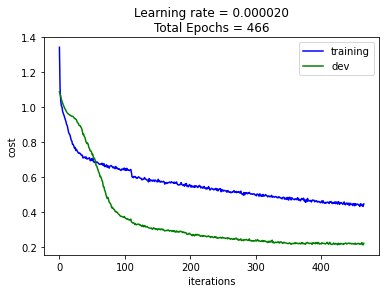

In [228]:
%tensorflow_version 1.x
parameters = model(X_train, Y_train, X_dev, Y_dev,
                   learning_rate=0.00002,
                   num_epochs=1000,
                   minibatch_size=128,
                   save_session_path='train/dataset-1024-1/cnn8_lr-0.00002_mbs-128/',
                   model_file='model',
                   restore_session=False,
                   save_session_interval=10,
                   nn_key='cnn8')

In [167]:
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        is_train = graph.get_tensor_by_name('is_train:0')
        
        epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
        print(epoch_counter.eval())

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            print('Accuracy: %f' % (y_hat_test == y_test).mean())
        

    return y_hat_test

In [168]:
def predict_voting(X_test_voting, session_path, model_file):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file
    
    y_hat_test_voting = []

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        is_train = graph.get_tensor_by_name('is_train:0')

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.gather(classname, tf.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [197]:
predictions = predict(X_dev, '/content/train/dataset-512-1/cnn8_lr-0.00002_mbs-128','/model.meta', Y_test_onehot=Y_dev)

print("\nPredicted values:")
print(predictions)

print("\nActual values:")
print(np.argmax(Y_test, 1))

INFO:tensorflow:Restoring parameters from /content/train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model

Predicted values:
(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), 1.0)

Actual values:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [198]:
testfile = '/content/random-iter-1/testset_voting_1024.h5'
session_path = '/content/train/dataset-512-1/cnn8_lr-0.00002_mbs-128'
model_file = '/model.meta'

with h5.File(testfile, 'r') as testfile:
    X_test_voting = testfile['X']
    X_test_voting = np.array(X_test_voting) / 1000
    y_test_voting = np.array(testfile['Y'])
    
    y_hat_test_voting = predict_voting(X_test_voting, session_path, model_file)
    
    print("Accuracy with voting: %f" % (y_test_voting == y_hat_test_voting).mean())

INFO:tensorflow:Restoring parameters from /content/train/dataset-512-1/cnn8_lr-0.00002_mbs-128/model
Accuracy with voting: 1.000000


In [199]:
def make_dimensions_compatible(arr):
    
    return arr.reshape(arr.shape[0],-1,1)

In [200]:
def load_dataset(dataset_iter=1, window_size=512):
    global X_train, Y_train, X_dev, Y_dev, X_test, Y_test
    
    dataset_relative_path = 'dataset/random-iter-%d/' % dataset_iter
    
    datafile = dataset_relative_path + 'datafile%d.h5' % window_size

    with h5.File(datafile, 'r') as datafile:
        X_train = np.array(datafile['X_train'])
        Y_train = np.array(datafile['Y_train'])

        X_dev = np.array(datafile['X_dev'])
        Y_dev = np.array(datafile['Y_dev'])

        X_test = np.array(datafile['X_test'])
        Y_test = np.array(datafile['Y_test'])
        
        # setting the rank of the data to be compatible with 1d convolution functions
        # defined in tensorflow
        X_train = make_dimensions_compatible(X_train)
        X_dev = make_dimensions_compatible(X_dev)
        X_test = make_dimensions_compatible(X_test)
        
        # normalization
        X_train = X_train / 1000
        X_dev = X_dev / 1000
        X_test = X_test / 1000

In [201]:
def get_session_path(dataset_iter=1, window_size=512, model_num=1, model_prefix='cnn', model_suffix='_lr-0.00002_mbs-128'):
    return ('train/dataset-%d-%d/' + model_prefix + '%d' + model_suffix + '/') % (window_size, dataset_iter, model_num)

In [202]:
def predict(X_test, session_path, model_file, Y_test_onehot=None):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        Y = graph.get_tensor_by_name('Y:0')
        is_train = graph.get_tensor_by_name('is_train:0')
        
#         epoch_counter = graph.get_tensor_by_name('epoch_counter:0')
#         print(epoch_counter.eval())

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)

        y_hat_test = predict_op.eval({X: X_test, is_train: False})
        
        # print the accuracy of the test set if the labels are provided
        if (Y_test_onehot is not None):
            y_test = np.argmax(Y_test_onehot, 1)
            acc = (y_hat_test == y_test).mean()
        

    return y_hat_test, acc

In [203]:
def predict_voting(X_test_voting, session_path, model_file):

    tf.reset_default_graph()

    checkpoint_path = session_path
    model_path = session_path + model_file
    
    y_hat_test_voting = []

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph(model_path)
        loader.restore(sess, tf.train.latest_checkpoint(checkpoint_path))

        graph = tf.get_default_graph()

        X = graph.get_tensor_by_name('X:0')
        is_train = graph.get_tensor_by_name('is_train:0')

        Y_hat = graph.get_tensor_by_name('softmax_output:0')

        predict_op = tf.argmax(Y_hat, 1)
        
        classname, idx, counts = tf.unique_with_counts(predict_op)
        predict_voting_op = tf.gather(classname, tf.argmax(counts))

        # no. of training examples with the original feature size
        m = X_test_voting.shape[0]
        
        # no. of split training examples of each original example
        m_each = X_test_voting.shape[1]
        
        for ex in range(m):
            x_test_voting = make_dimensions_compatible(X_test_voting[ex])
            pred = predict_voting_op.eval({X: x_test_voting, is_train: False})
            
            y_hat_test_voting.append(pred)

    return y_hat_test_voting

In [238]:
# Run the following code to call the above define predict method and check accuracy of the models

model_num = 1
window_size = 1024
iter = (1)

accuracies = np.array([])

load_dataset(iter, window_size)
session_path = '/content/train/dataset-1024-1/cnn8_lr-0.00002_mbs-128'
predictions, acc = predict(X_test, session_path, '/model.meta', Y_test_onehot=Y_test)
accuracies = np.append(accuracies, acc)

accuracies = accuracies * 100
print(accuracies)

print("Mean accuracy: %f" % accuracies.mean())

INFO:tensorflow:Restoring parameters from /content/train/dataset-1024-1/cnn8_lr-0.00002_mbs-128/model
[98.28571429]
Mean accuracy: 98.285714


In [239]:
from numpy.lib.function_base import bartlett
model_num = 1
window_size = 1024
dataset_iters = (1)


accuracies_voting = np.array([])
sensitivities_voting = np.array([])
specificities_voting = np.array([])
precisions_voting = np.array([])

dataaset_relative_path = '/content/random-iter-1/'
testfile = (dataset_relative_path + '/testset_voting_%d.h5') % window_size
session_path = get_session_path(dataset_iter, window_size, model_num)
model_file = '/model.meta'



with h5.File(testfile, 'r') as testfile:
  
  X_test_voting = testfile['X']
  X_test_voting = np.array(X_test_voting) / 1000
  y_test_voting = np.array(testfile['Y'])
        
  no_of_classes = 3
  session_path = '/content/train/dataset-1024-1/cnn8_lr-0.00002_mbs-128'
  y_hat_test_voting = np.array(predict_voting(X_test_voting, session_path, model_file))

  acc_voting_model = (y_test_voting == y_hat_test_voting).mean()
  accuracies_voting = np.append(accuracies_voting, acc_voting_model)
        
        # specificity and sensitivity
  specificity = 0
  sensitivity = 0
  precision = 0
  for i in range(no_of_classes):
    
    specificity_vector = ((y_hat_test_voting != i) == (y_test_voting != i))[y_test_voting != i]
    sensitivity_vector = ((y_hat_test_voting == i) == (y_test_voting == i))[y_test_voting == i]
    precision_vector = ((y_hat_test_voting == i) == (y_test_voting == i))[y_hat_test_voting == i]
            
    specificity = specificity + specificity_vector.sum() / len(specificity_vector)
    sensitivity = sensitivity + sensitivity_vector.sum() / len(sensitivity_vector)
    precision = precision + precision_vector.sum() / len(precision_vector)
        
    specificity = specificity / no_of_classes
    sensitivity = sensitivity / no_of_classes
    precision = precision / no_of_classes
        
    specificities_voting = np.append(specificities_voting, specificity)
    sensitivities_voting = np.append(sensitivities_voting, sensitivity)
    precisions_voting = np.append(precisions_voting, precision)


# Computing F-Score
Pre = precisions_voting.mean()
Sen = sensitivities_voting.mean()
F_Score = (2 * Pre * Sen) / (Pre + Sen)
        
accuracies_voting = accuracies_voting * 100
print("Accuracy with voting: ", accuracies_voting)
print("Mean accuracy with voting: %f" % accuracies_voting.mean())
print("\n\n")
print("Specifities: ", specificities_voting)
print("Mean specificity with voting: %f" % specificities_voting.mean())
print("\n\n")
print("Sensitivities: ", sensitivities_voting)
print("Mean sensitivity with voting: %f" % sensitivities_voting.mean())
# print("Mean precision with voting: %f" % Pre)
print("Mean F-Score with voting: %f" % F_Score)
print("Standard deviation: %f" % accuracies_voting.std())

# print("Actual labels:\n", y_test_voting)
# print("\n\nPredictions:\n", y_hat_test_voting)


INFO:tensorflow:Restoring parameters from /content/train/dataset-1024-1/cnn8_lr-0.00002_mbs-128/model
Accuracy with voting:  [100.]
Mean accuracy with voting: 100.000000



Specifities:  [0.33333333 0.44444444 0.48148148]
Mean specificity with voting: 0.419753



Sensitivities:  [0.33333333 0.44444444 0.48148148]
Mean sensitivity with voting: 0.419753
Mean F-Score with voting: 0.419753
Standard deviation: 0.000000
